In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
train = pd.read_csv("/content/drive/My Drive/train_FD.csv")
test = pd.read_csv("/content/drive/My Drive/test_FD.csv")

In [ ]:
id_columns = [i for i in train.columns if i.startswith("i")]
id_columns.remove("isFraud")
for i in id_columns:
  id_null = train[i].isnull().sum()
  print("{}% of null points in {}".format(np.round((id_null/train.shape[0]*100),2),i))

75.58% of null points in id_01
76.15% of null points in id_02
88.77% of null points in id_03
88.77% of null points in id_04
76.82% of null points in id_05
76.82% of null points in id_06
99.13% of null points in id_07
99.13% of null points in id_08
87.31% of null points in id_09
87.31% of null points in id_10
76.13% of null points in id_11
75.58% of null points in id_12
78.44% of null points in id_13
86.45% of null points in id_14
76.13% of null points in id_15
78.1% of null points in id_16
76.4% of null points in id_17
92.36% of null points in id_18
76.41% of null points in id_19
76.42% of null points in id_20
99.13% of null points in id_21
99.12% of null points in id_22
99.12% of null points in id_23
99.2% of null points in id_24
99.13% of null points in id_25
99.13% of null points in id_26
99.12% of null points in id_27
76.13% of null points in id_28
76.13% of null points in id_29
86.86% of null points in id_30
76.25% of null points in id_31
86.86% of null points in id_32
87.59% of n

In [ ]:
id_columns = [i for i in test.columns if i.startswith("i")]
for i in id_columns:
  id_null = test[i].isnull().sum()
  print("{}% of null points in {}".format(np.round((id_null/test.shape[0]*100),2),i))

71.99% of null points in id-01
72.97% of null points in id-02
86.88% of null points in id-03
86.88% of null points in id-04
73.41% of null points in id-05
73.41% of null points in id-06
99.0% of null points in id-07
99.0% of null points in id-08
85.33% of null points in id-09
85.33% of null points in id-10
73.01% of null points in id-11
71.99% of null points in id-12
74.29% of null points in id-13
85.92% of null points in id-14
72.97% of null points in id-15
75.18% of null points in id-16
73.17% of null points in id-17
89.96% of null points in id-18
73.18% of null points in id-19
73.23% of null points in id-20
99.0% of null points in id-21
99.0% of null points in id-22
99.0% of null points in id-23
99.06% of null points in id-24
99.01% of null points in id-25
99.0% of null points in id-26
99.0% of null points in id-27
73.01% of null points in id-28
73.01% of null points in id-29
86.05% of null points in id-30
73.04% of null points in id-31
86.05% of null points in id-32
86.05% of null 

In the train data all the id_x features contain more than 75% missing value, and in test all the id_x features contain more than 70% missing value.

So lets remove all the id_x features which contain >=80% of missing value and use rest features because if a feature has such a huge missing values does not contributes in the classification of fraud transactions from legit transactions.

In [ ]:
train.drop(["id_03","id_04","id_07","id_08","id_09","id_10","id_14","id_18","id_21","id_22","id_23","id_24","id_25","id_26","id_27"], axis=1, inplace=True)
test.drop(["id-03","id-04","id-07","id-08","id-09","id-10","id-14","id-18","id-21","id-22","id-23","id-24","id-25","id-26","id-27"], axis=1, inplace=True)

I did not remove id_30,id_32,id_33 and id_34 even it has more than 80% missing values , because these features have some interesting properties for classification.

In [ ]:
test_TID = list(test["TransactionID"].values)

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,transactionPrDay,hour,Alert,logTransactionAmt,card4_counts,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,browser_id_31,version_id_31,os_counts,screen_width,screen_height,TransDecimalCount,device_name,device_version
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,98502,0,noalert,4.227,6651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,98502,0,noalert,3.367,189215.0,google,com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,98502,0,noalert,4.080,384767.0,microsoft,com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,98502,0,noalert,3.912,189215.0,yahoo,com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,100.0,NotFound,NaN,New,NotFound,166.0,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,1,98502,0,noalert,3.912,189215.0,google,com,NaN,NaN,samsung,browser,Android,2220.0,1080.0,1,Samsung,NRD90M


In [ ]:
# I have to remove this feature because i have created some features from this.
train.drop(["DeviceInfo"], axis=1, inplace=True)
test.drop(["DeviceInfo"], axis=1, inplace=True)

### Some Aggregation feature engineering :

In [ ]:
# https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data
# Some arbitrary Aggregation feature engineering.
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')
test['id_02_to_mean_card1'] = test['id-02'] / test.groupby(['card1'])['id-02'].transform('mean')
test['id_02_to_mean_card4'] = test['id-02'] / test.groupby(['card4'])['id-02'].transform('mean')
test['id_02_to_std_card1'] = test['id-02'] / test.groupby(['card1'])['id-02'].transform('std')
test['id_02_to_std_card4'] = test['id-02'] / test.groupby(['card4'])['id-02'].transform('std')
train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')
test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')
train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')
test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

## Analysis on Vx features :

In [ ]:
vfeatures=[]
for c in train.columns:
  if c.startswith("V"):
    vfeatures.append(c)
train_v = train[vfeatures]    

In [ ]:
for v in vfeatures:
  train_v[v].fillna(train_v[v].median(), inplace=True)

In [ ]:
v_x = train_v[:int(train.shape[0]*0.70)]
v_cv = train_v[int(train.shape[0]*0.70):]
train_y = train["isFraud"].values[:int(train.shape[0]*0.70)]
cv_y = train["isFraud"].values[int(train.shape[0]*0.70):]

In [ ]:
clf = LGBMClassifier()
clf.fit(v_x, train_y)
print("Train AUC :",roc_auc_score(train_y, clf.predict_proba(v_x)[:,1]))
print("CV AUC :",roc_auc_score(cv_y, clf.predict_proba(v_cv)[:,1]))

Train AUC : 0.8827452658031207
CV AUC : 0.8456935374938779


In [ ]:
vremove=[]
for j,i in enumerate(clf.feature_importances_):
  if i<3:
    vremove.append(vfeatures[j])  
len(vremove)  

122

In [ ]:
print(len(vfeatures))
for v in vremove:
    vfeatures.remove(v)
print(len(vfeatures))    

339
217


In [ ]:
train_v = train[vfeatures]
for v in vfeatures:
  train_v[v].fillna(train_v[v].median(), inplace=True)

In [ ]:
v_x = train_v[:int(train.shape[0]*0.70)]
v_cv = train_v[int(train.shape[0]*0.70):]

In [ ]:
clf = LGBMClassifier()
clf.fit(v_x, train_y)
print("Train AUC :",roc_auc_score(train_y, clf.predict_proba(v_x)[:,1]))
print("CV AUC :",roc_auc_score(cv_y, clf.predict_proba(v_cv)[:,1]))

Train AUC : 0.8834913012795769
CV AUC : 0.845279814801697


after removing all the v_features which has les than 3 importance score the auc score does not changed ,  so we have to remove those features.

In [ ]:
train.drop(vremove,axis=1,inplace=True)
test.drop(vremove, axis=1,inplace=True)

In [ ]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,day,transactionPrDay,hour,Alert,logTransactionAmt,card4_counts,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,browser_id_31,version_id_31,os_counts,screen_width,screen_height,TransDecimalCount,device_name,device_version,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,addr1_count_full,addr2_count_full,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,98502,0,noalert,4.227,6651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,56,17587,956817,9523,309,267642,43034,956389,0.194637,0.257727,0.184560,0.170231,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1,98502,0,noalert,3.367,189215.0,google,com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1338,5593,956817,347377,49487,267642,76901,956389,0.123781,0.219612,0.063008,0.125051,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1,98502,0,noalert,4.080,384767.0,microsoft,com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1794,70493,956817,719626,102927,824977,48386,956389,0.608149,0.443059,0.589226,0.258543,NaN,NaN,NaN,NaN,2.518583,1.865817,1.851016,1.541435,1.611525,1.486472


In [ ]:
train.drop(["P_emaildomain", "R_emaildomain"], axis=1, inplace=True)
test.drop(["P_emaildomain", "R_emaildomain"], axis=1, inplace=True)

train.drop(["TransactionID",	"TransactionDT",	"TransactionAmt"], axis=1, inplace=True)
test.drop(["TransactionID",	"TransactionDT",	"TransactionAmt"], axis=1, inplace=True)

##Imputation of missing values :

In [ ]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)

In [ ]:
# imputation of numerical features by median of there column.
for i in train.columns:
    if train[i].dtypes=='int64' or train[i].dtypes=='int32' or train[i].dtypes=='int16' or train[i].dtypes=='int8' or train[i].dtypes=='float64' or train[i].dtypes=='float32' or train[i].dtypes=='float16' :
        train[i].fillna(train[i].median(),inplace=True)

In [ ]:
# imputation of categorical value by mode of there column.
for i in train.columns:
    if train[i].dtypes=='object':
        train[i].fillna(train[i].mode()[0],inplace=True)

In [ ]:
train.isnull().sum()

isFraud              0
ProductCD            0
card1                0
card2                0
card3                0
                    ..
D15_to_mean_card4    0
D15_to_std_card1     0
D15_to_std_card4     0
D15_to_mean_addr1    0
D15_to_std_addr1     0
Length: 330, dtype: int64

In [ ]:
# imputation of numerical features median of there column.
for i in test.columns:
    if test[i].dtypes=='int64' or test[i].dtypes=='int32' or test[i].dtypes=='int16' or test[i].dtypes=='int8' or test[i].dtypes=='float64' or test[i].dtypes=='float32' or test[i].dtypes=='float16' :
        test[i].fillna(test[i].median(),inplace=True)

In [ ]:
# imputation of categorical features by mode.
for i in test.columns:
    if test[i].dtypes=='object':
        test[i].fillna(test[i].mode()[0],inplace=True)

In [ ]:
# encoding categorical feature to numerical value.
from sklearn.preprocessing import LabelEncoder

for i in train.columns:
  if train[i].dtypes=="object":
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i].astype(str).values)

In [ ]:
for i in test.columns:
  if test[i].dtypes=="object":
    le = LabelEncoder()
    test[i] = le.fit_transform(test[i].astype(str).values)

### Split 70:30 (Training and Validation dataset)

In [ ]:
train_x = train[:int(train.shape[0]*0.70)]
cv_x = train[int(train.shape[0]*0.70):]
train_y = train_x["isFraud"].values
train_x.drop(["isFraud"], axis=1, inplace=True)
cv_y = cv_x["isFraud"].values
cv_x.drop(["isFraud"], axis=1, inplace=True)

In [ ]:
columns = list(train_x.columns)
del train

In [ ]:
#standardizing the train_x and cv_x : mean centring and variance scaling.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
cv_x = sc.transform(cv_x)
test = sc.transform(test)

In [ ]:
np.nan_to_num(train_x, copy=False)
np.nan_to_num(cv_x, copy=False)
np.nan_to_num(test, copy=False)

array([[ 0.58291462,  0.11054791, -1.60949586, ...,  0.94177176,
         0.78083152,  0.68078257],
       [ 0.58291462, -1.14136043, -1.60949586, ...,  1.87718763,
         2.31842194,  1.46789879],
       [ 0.58291462, -1.09974575,  1.34149562, ..., -0.35533825,
        -0.3651044 , -0.33752049],
       ...,
       [ 0.58291462,  1.38591551,  0.80611055, ..., -0.75860643,
        -0.84117092, -0.66331046],
       [ 0.58291462,  1.37775577,  0.97182498, ..., -0.75860643,
        -0.84117092, -0.66331046],
       [-2.15643865, -0.84740575, -1.24619885, ..., -0.75860643,
        -0.43892466, -0.36213275]])

In [ ]:
train_x.shape

(413354, 329)

In [ ]:
from sklearn.metrics import confusion_matrix
 # This function is use to plot confusion, precision and recall matrix .
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
 
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## **Logistic Regression model :**

In [ ]:
param = {"alpha":[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
clf = SGDClassifier(loss="log", class_weight='balanced', penalty="l2")
rand_clf = RandomizedSearchCV(clf, param, scoring="roc_auc", return_train_score=True)
rand_clf.fit(train_x, train_y)
print(rand_clf.best_params_)
print("="*100)
print(rand_clf.best_estimator_)

{'alpha': 0.001}
SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
print(rand_clf.cv_results_["mean_train_score"])
print("="*50)
print(rand_clf.cv_results_["mean_test_score"])

[0.86223628 0.87156513 0.86884199 0.85934611 0.83541186 0.81335897
 0.80240818 0.79950443 0.79914044]
[0.84204804 0.85250243 0.85152211 0.84755539 0.8281826  0.80827574
 0.79847384 0.79589737 0.79549251]


In [ ]:
clf_lr = SGDClassifier(loss="log", class_weight="balanced", alpha=rand_clf.best_params_["alpha"], penalty="l2")
clf_lr.fit(train_x, train_y)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### confusion matrix, precision and recall matrix.

Train AUC = 0.8698140089036914
-------------------- Confusion matrix --------------------


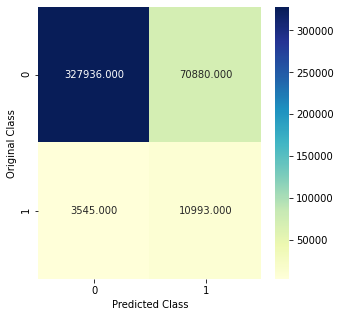

-------------------- Precision matrix (Columm Sum=1) --------------------


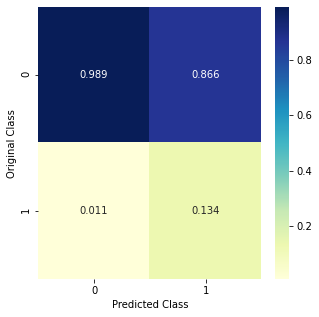

-------------------- Recall matrix (Row sum=1) --------------------


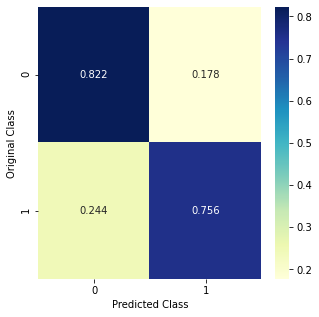

In [ ]:
pred = clf_lr.predict(train_x)
pred_prob = clf_lr.predict_proba(train_x)
print("Train AUC =",roc_auc_score(train_y, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(train_y, pred)

CV AUC = 0.8327961216567423
-------------------- Confusion matrix --------------------


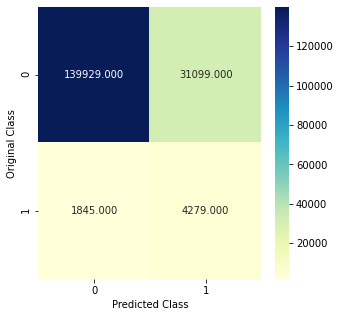

-------------------- Precision matrix (Columm Sum=1) --------------------


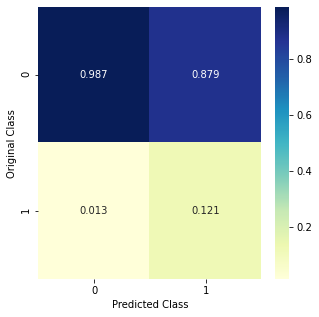

-------------------- Recall matrix (Row sum=1) --------------------


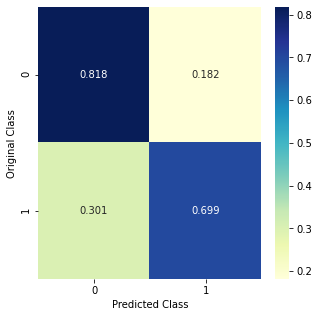

In [ ]:
pred = clf_lr.predict(cv_x)
pred_prob = clf_lr.predict_proba(cv_x)
print("CV AUC =",roc_auc_score(cv_y, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(cv_y, pred)

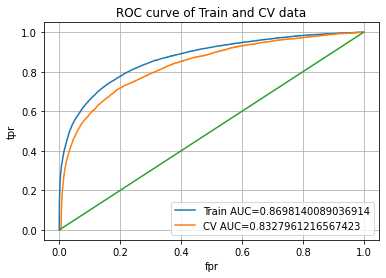

In [ ]:
# ploting ROC AUC curve.
pred_train = clf_lr.predict(train_x)
pred_prob_train = clf_lr.predict_proba(train_x)
pred_cv = clf_lr.predict(cv_x)
pred_prob_cv = clf_lr.predict_proba(cv_x)
 
train_fpr,train_tpr,tr_thresholds=roc_curve(train_y, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(cv_y, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

### **Features Importance :**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

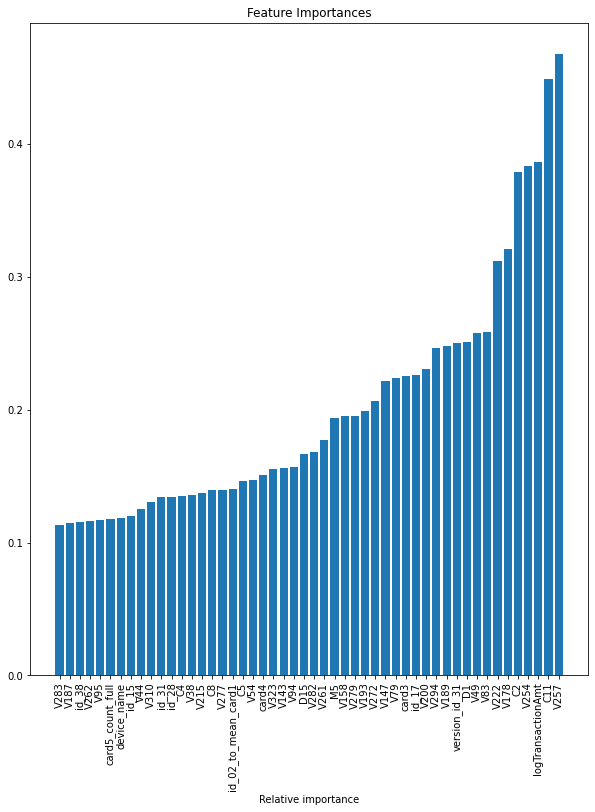

In [ ]:
features = columns
importances = clf_lr.coef_.reshape(-1, )
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

## **LGBM Model :**

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'max_depth':[1,3,4,5],
             'learning_rate':[0.001,0.01,0.1], 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'n_estimators':[100,300,500,600,800,1100],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 12]}

In [ ]:
clf = LGBMClassifier(class_weight='balanced')
rand_clf = RandomizedSearchCV(clf, param_test, scoring="roc_auc", return_train_score=True)
rand_clf.fit(train_x, train_y)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 446, 'min_child_weight': 0.001, 'n_estimators': 1100, 'reg_alpha': 7, 'reg_lambda': 0.1, 'subsample': 0.20426008083869115}
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=5, min_child_samples=446,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=7, reg_lambda=0.1, silent=True,
               subsample=0.20426008083869115, subsample_for_bin=200000,
               subsample_freq=0)


In [ ]:
print(rand_clf.cv_results_["mean_train_score"])
print("="*100)
print(rand_clf.cv_results_["mean_test_score"])

[0.85517556 0.76226918 0.86115438 0.78823374 0.91556296 0.92918147
 0.86094282 0.84507894 0.81398281 0.81398289]
[0.84880126 0.75374534 0.85288021 0.7738907  0.89449373 0.9030336
 0.84914896 0.83742383 0.80177063 0.80177102]


In [ ]:
clf_lgbm = LGBMClassifier(class_weight="balanced", max_depth=5, min_child_samples=446, min_child_weight=0.001, n_estimators=1100, reg_alpha=7, reg_lambda=0.1, subsample=0.2043, learning_rate=0.01)
clf_lgbm.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=5, min_child_samples=446,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=7, reg_lambda=0.1, silent=True, subsample=0.2043,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred_train = clf_lgbm.predict(train_x)
pred_prob_train = clf_lgbm.predict_proba(train_x)
pred_cv = clf_lgbm.predict(cv_x)
pred_prob_cv = clf_lgbm.predict_proba(cv_x)

Train AUC = 0.9267882729964199
-------------------- Confusion matrix --------------------


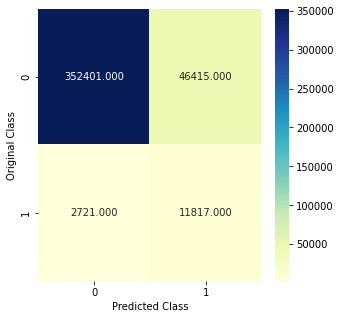

-------------------- Precision matrix (Columm Sum=1) --------------------


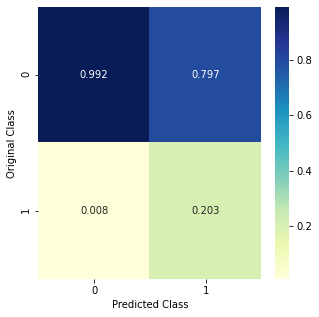

-------------------- Recall matrix (Row sum=1) --------------------


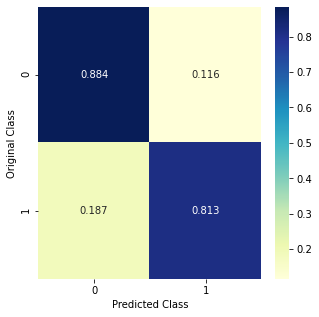

In [ ]:
print("Train AUC =",roc_auc_score(train_y, pred_prob_train[:,1]))
print("="*100)
plot_confusion_matrix(train_y, pred_train)

CV AUC = 0.8943751840123291
-------------------- Confusion matrix --------------------


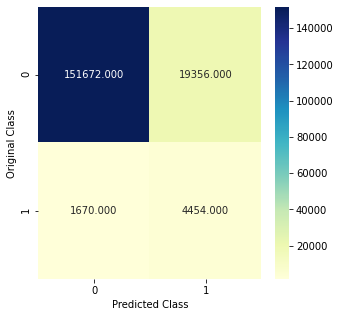

-------------------- Precision matrix (Columm Sum=1) --------------------


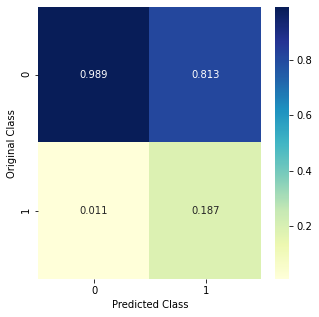

-------------------- Recall matrix (Row sum=1) --------------------


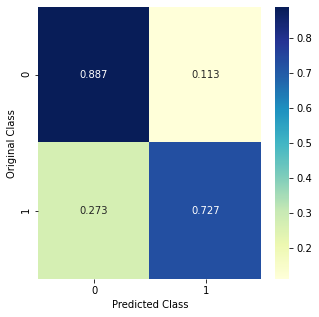

In [ ]:
print("CV AUC =",roc_auc_score(cv_y, pred_prob_cv[:,1]))
print("="*100)
plot_confusion_matrix(cv_y, pred_cv)

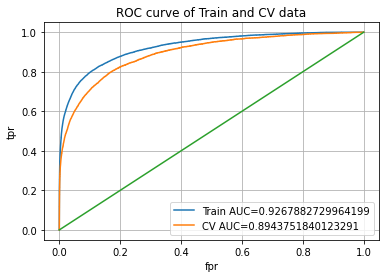

In [ ]:
train_fpr,train_tpr,tr_thresholds=roc_curve(train_y, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(cv_y, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

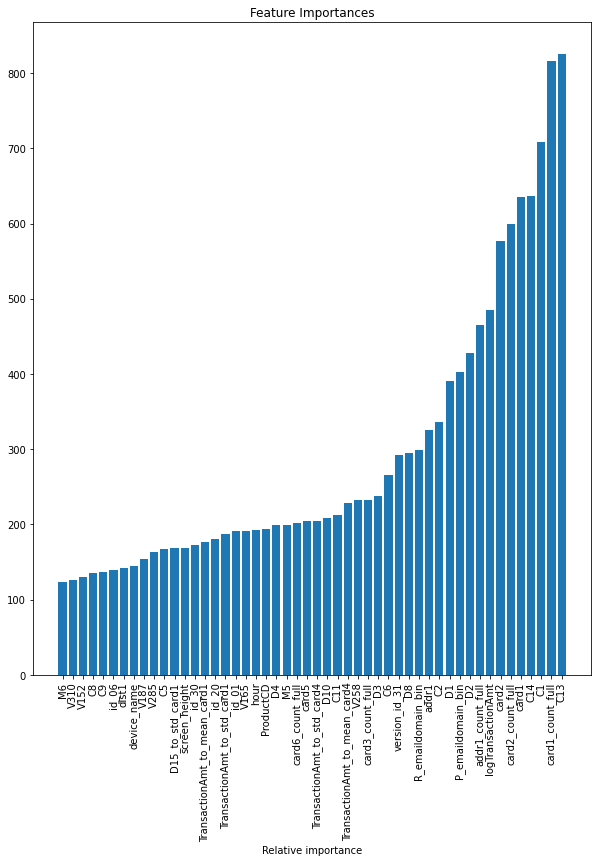

In [ ]:
features = columns
importances = clf_lgbm.feature_importances_
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

## **Applying of models after removing correlated features of D and C :**

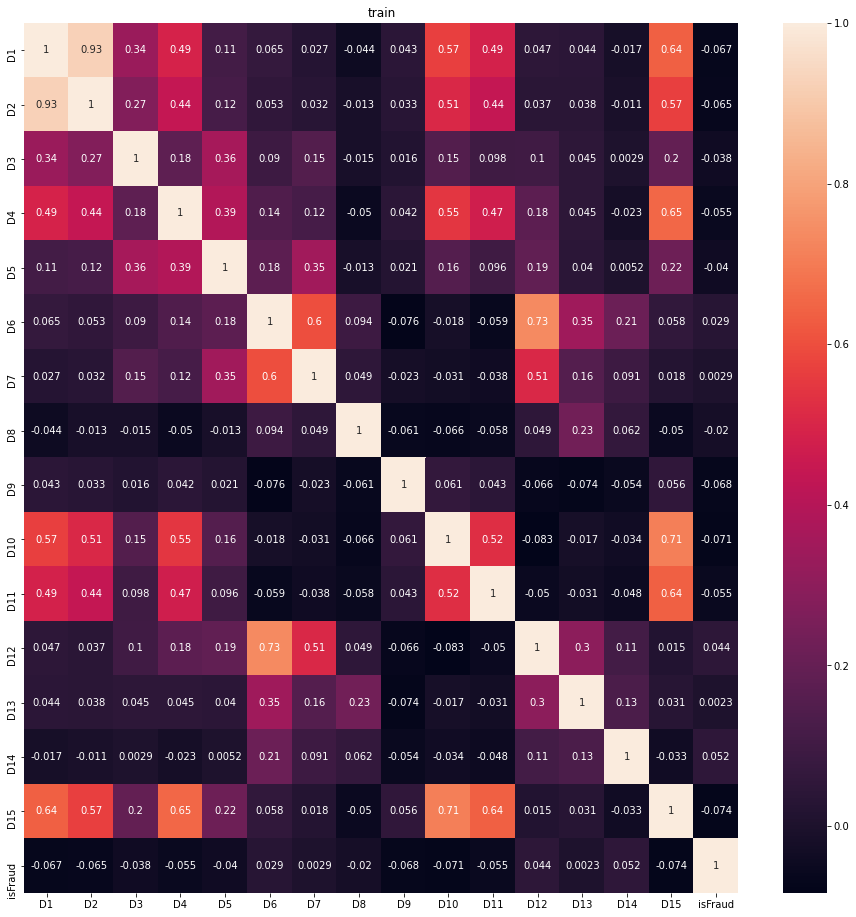

In [ ]:
cor_d = train[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','isFraud']].corr()
plt.figure(1,figsize=(16,16))
sns.heatmap(cor_d,annot=True)
plt.title('train')
plt.show()



*   correlation between D1 and D2 si very high =1, between D6 and D12 0.73, D10 and D15 correlation is 0.71
*   List item



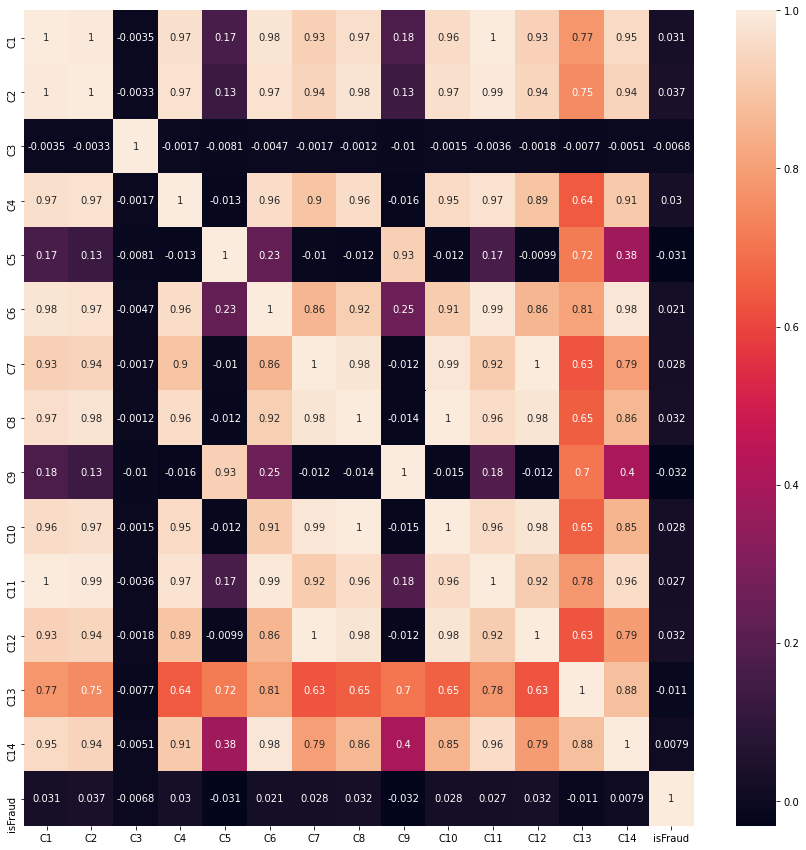

In [ ]:
cor_c = train[['C1','C2',"C3",'C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','isFraud']].corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor_c, annot=True)
plt.show()

In [ ]:
train.drop(["D2","D6","D10","C1","C4","C6","C8","C11"], axis=1, inplace=True)
test.drop(["D2","D6","D10","C1","C4","C6","C8","C11"], axis=1, inplace=True)

In [ ]:
train_x = train[:int(train.shape[0]*0.70)]
cv_x = train[int(train.shape[0]*0.70):]
train_y = train_x["isFraud"].values
train_x.drop(["isFraud"], axis=1, inplace=True)
cv_y = cv_x["isFraud"].values
cv_x.drop(["isFraud"], axis=1, inplace=True)

In [ ]:
columns = list(train_x.columns)

In [ ]:
#standardizing the train_x and cv_x 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
cv_x = sc.transform(cv_x)
test = sc.transform(test)

In [ ]:
np.nan_to_num(train_x, copy=False)
np.nan_to_num(cv_x, copy=False)
np.nan_to_num(test, copy=False)
train_x.shape

(413354, 320)

## **Logistic Regression :**

In [ ]:
param = {"alpha":[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
clf = SGDClassifier(loss="log", class_weight='balanced', penalty="l2")
rand_clf = RandomizedSearchCV(clf, param, scoring="roc_auc", return_train_score=True)
rand_clf.fit(train_x, train_y)
print(rand_clf.best_params_)
print("="*100)
print(rand_clf.best_estimator_)

{'alpha': 0.01}
SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
clf_lr = SGDClassifier(loss="log", class_weight="balanced", alpha=rand_clf.best_params_["alpha"], penalty="l2")
clf_lr.fit(train_x, train_y)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Train AUC = 0.8668010176748573
-------------------- Confusion matrix --------------------


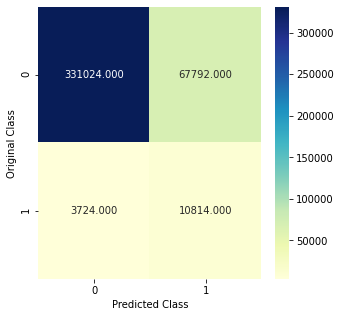

-------------------- Precision matrix (Columm Sum=1) --------------------


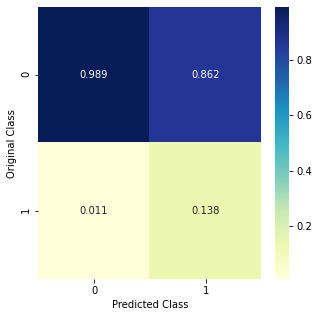

-------------------- Recall matrix (Row sum=1) --------------------


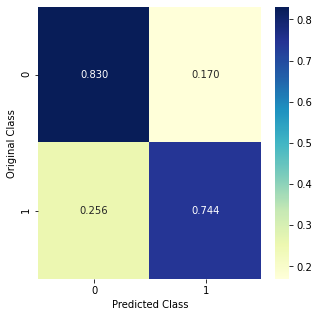

In [ ]:
pred = clf_lr.predict(train_x)
pred_prob = clf_lr.predict_proba(train_x)
print("Train AUC =",roc_auc_score(train_y, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(train_y, pred)

CV AUC = 0.8338224489182997
-------------------- Confusion matrix --------------------


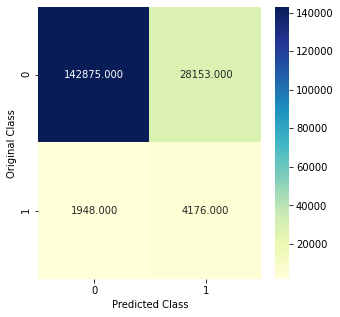

-------------------- Precision matrix (Columm Sum=1) --------------------


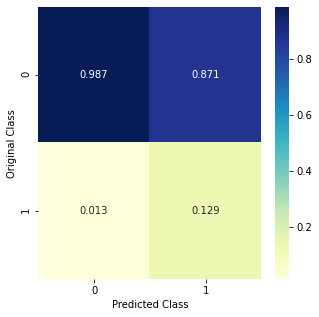

-------------------- Recall matrix (Row sum=1) --------------------


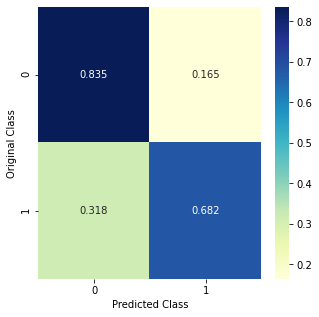

In [ ]:
pred = clf_lr.predict(cv_x)
pred_prob = clf_lr.predict_proba(cv_x)
print("CV AUC =",roc_auc_score(cv_y, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(cv_y, pred)

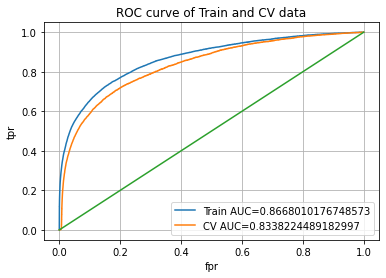

In [ ]:
pred_train = clf_lr.predict(train_x)
pred_prob_train = clf_lr.predict_proba(train_x)
pred_cv = clf_lr.predict(cv_x)
pred_prob_cv = clf_lr.predict_proba(cv_x)

train_fpr,train_tpr,tr_thresholds=roc_curve(train_y, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(cv_y, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

After removing correlation features the performance of Logistic regression model did not change.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

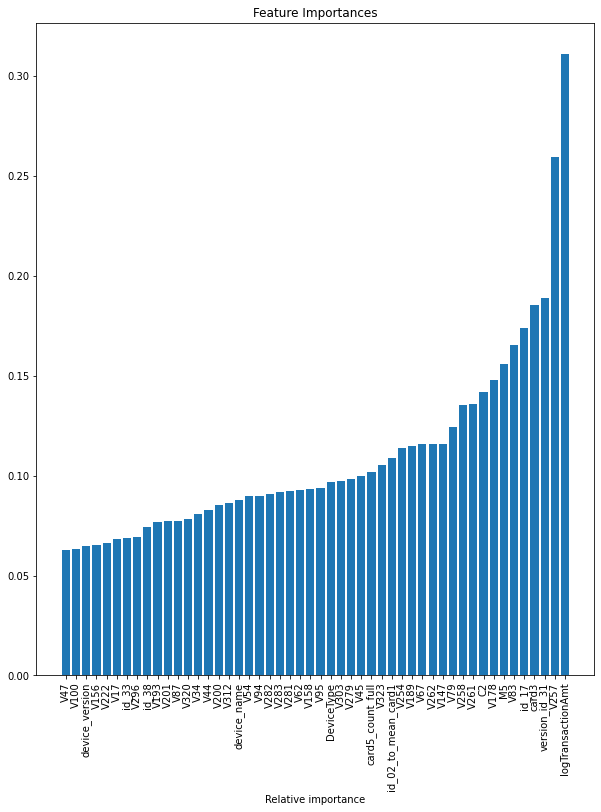

In [ ]:
features = columns
importances = clf_lr.coef_.reshape(-1, )
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

## **LGBMClassifier model :**

In [ ]:
clf = LGBMClassifier(class_weight='balanced')
rand_clf = RandomizedSearchCV(clf, param_test, scoring="roc_auc", return_train_score=True)
rand_clf.fit(train_x, train_y)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

In [ ]:
clf_lgbm = LGBMClassifier(class_weight="balanced", max_depth=4, min_child_samples=189, min_child_weight=10.0, n_estimators=800, reg_alpha=7, subsample=0.8243, learning_rate=0.01)
clf_lgbm.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=4, min_child_samples=189,
               min_child_weight=10.0, min_split_gain=0.0, n_estimators=800,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=7, reg_lambda=0.0, silent=True, subsample=0.8243,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred_train = clf_lgbm.predict(train_x)
pred_prob_train = clf_lgbm.predict_proba(train_x)
pred_cv = clf_lgbm.predict(cv_x)
pred_prob_cv = clf_lgbm.predict_proba(cv_x)

Train AUC = 0.9031611955751753
-------------------- Confusion matrix --------------------


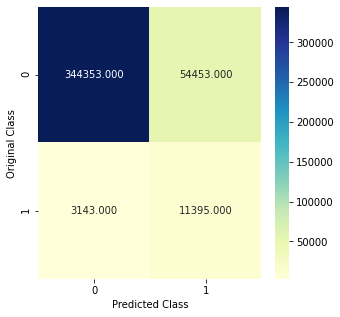

-------------------- Precision matrix (Columm Sum=1) --------------------


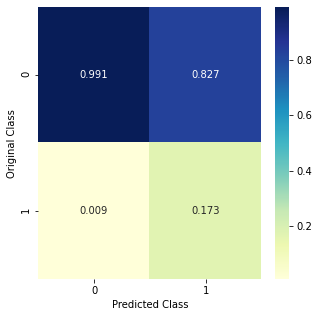

-------------------- Recall matrix (Row sum=1) --------------------


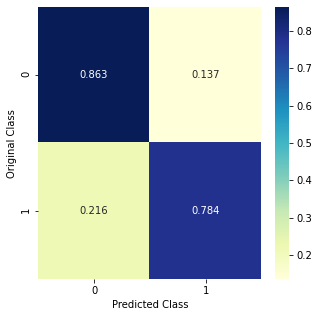

In [ ]:
print("Train AUC =",roc_auc_score(train_y, pred_prob_train[:,1]))
print("="*100)
plot_confusion_matrix(train_y, pred_train)

CV AUC = 0.8818866224819742
-------------------- Confusion matrix --------------------


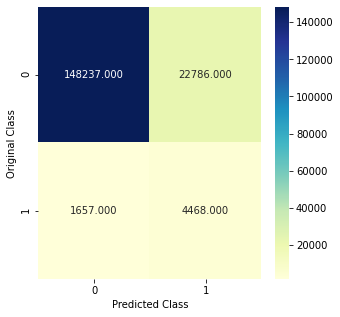

-------------------- Precision matrix (Columm Sum=1) --------------------


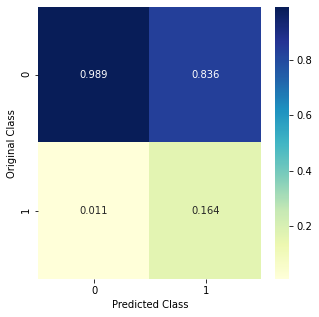

-------------------- Recall matrix (Row sum=1) --------------------


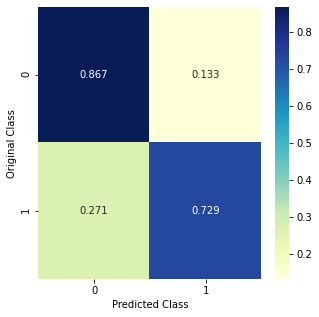

In [ ]:
print("CV AUC =",roc_auc_score(cv_y, pred_prob_cv[:,1]))
print("="*100)
plot_confusion_matrix(cv_y, pred_cv)

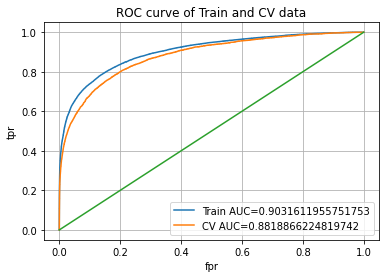

In [ ]:
train_fpr,train_tpr,tr_thresholds=roc_curve(train_y, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(cv_y, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

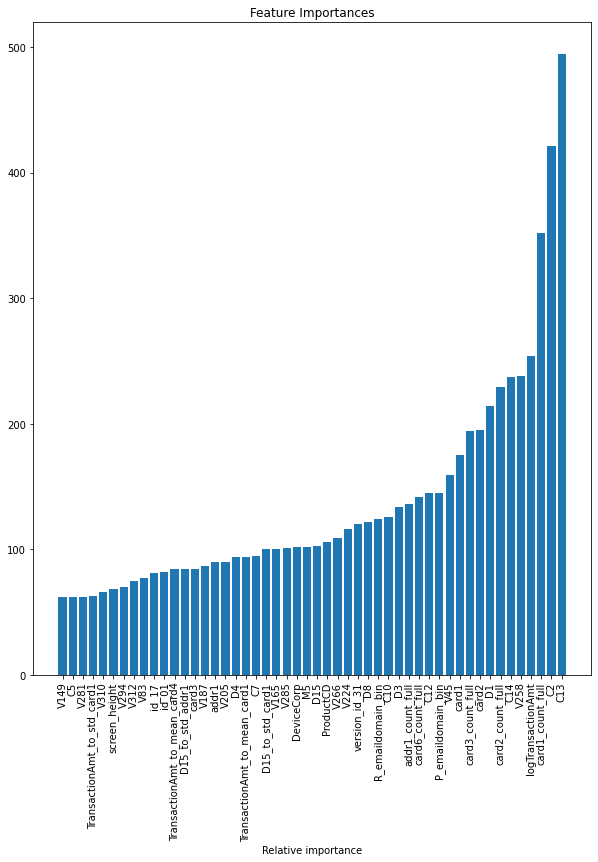

In [ ]:
features = columns
importances = clf_lgbm.feature_importances_
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

removing the correlated feaures did not effect the performance of model very much but can reduce the training time .